In [158]:
import os
from IPython.display import display
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style(theme='chesterish')
import pickle
from scipy.spatial.distance import euclidean #used for fdt
import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)

from pmdarima.arima import auto_arima
import xgboost as xgb #xgboost model
import tensorflow as tf #DNN estimator model
%matplotlib inline
path = '../input/'

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from keras import optimizers, models
from keras.callbacks import EarlyStopping
from datetime import datetime
from os import listdir
import joblib

from sklearn.preprocessing import StandardScaler

In [159]:
DATA_DIR = r'C:\Users\yashc\DataspellProjects\DemandForecastingGCP/forecasting_ensemble/data/raw/store_item/'
MAIN_DIR = '\\'.join(os.getcwd().split('\\')[:-1])
MODEL_DIR = MAIN_DIR + '\\models\\'
OBJECTS_DIR = MAIN_DIR + '\\objects\\'
SCALER_FILE = 'scaler_info.save'
TRAIN_PATH = DATA_DIR + 'train.csv'
TEST_PATH = DATA_DIR + 'test.csv'
GROUPED_COLS = ['item','store','date']
LABEL_COL = 'sales'
INDEX_COL = 'date'

LSTM_PARAMS = {
    'LSTM_WINDOW_LENGTH':29,
    'LSTM_PREDICTION_LAG':90,
    'LSTM_NODES':30,
    'LSTM_EPOCHS':10,
    'LSTM_BATCH':256,
    'LSTM_LR':0.003
}

XGB_PARAMS = {
    'XGB_MAX_DEPTH':3,
    'XGB_ETA':0.2,
    'XGB_SILENT':1,
    'XGB_SUBSAMPLE':1,
    'XGB_NUM_ROUNDS':1000
}

In [160]:
def SMAPE(forecast, actual):
    """Returns the Symmetric Mean Absolute Percentage Error between two Series"""
    if len(actual.shape)!=2:
        actual = actual.reshape(actual.shape[0],1)
    masked_arr = ~((forecast==0)&(actual==0))
    diff = abs(forecast[masked_arr] - actual[masked_arr])
    avg = (abs(forecast[masked_arr]) + abs(actual[masked_arr]))/2

    print('SMAPE Error Score: ' + str(round(sum(diff/avg)/len(forecast) * 100, 2)) + ' %')

In [161]:
def plot_pred_vs_act(actual, predicted, model_type):
    plt.rcParams["figure.figsize"] = [16,9]
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.legend()
    plt.title(f'Predicted vs Actual Sales for {model_type} Model')

In [162]:
def Fuller(TimeSeries):
    """Provides Fuller test results for TimeSeries"""
    stationary_test = adfuller(TimeSeries)
    print('ADF Statistic: %f' % stationary_test[0])
    print('p-value: %f' % stationary_test[1])
    print('Critical Values:')
    for key, value in stationary_test[4].items():
        print('\t%s: %.3f' % (key, value))

In [163]:
def xboost(x_train, y_train, x_test, xgb_params):
    """Trains xgboost model and returns it"""

    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    params = {'max_depth':xgb_params['XGB_MAX_DEPTH'],
              'eta':xgb_params['XGB_ETA'],
              'silent':xgb_params['XGB_SILENT'],
              'subsample':xgb_params['XGB_SUBSAMPLE']}

    xgb_model = xgb.train(params, dtrain, xgb_params['XGB_NUM_ROUNDS'])

    return xgb_model

In [164]:
def lstm_model(params,x_train, y_train, x_valid, y_valid, lstm_model_dir,is_trained=0):

    folder_name = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
    save_path = f'model-{folder_name}'

    if is_trained:
        fnf = listdir(lstm_model_dir)
        sorted_lstm_models = [x for x in fnf if ('model' in str(x)) & ('xgb' not in str(x))]
        sorted_lstm_models.sort(reverse=True)
        model_lstm = models.load_model(lstm_model_dir+str(sorted_lstm_models[0]))

    else:
        callback = EarlyStopping(monitor='val_loss', patience=2)
        model_lstm = Sequential()
        model_lstm.add(LSTM(params['LSTM_NODES'], activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
        model_lstm.add(Dense(1))
        model_lstm.compile(loss='mse', optimizer=optimizers.Adam(LSTM_PARAMS['LSTM_LR']))
        model_lstm.summary()
        lstm_history = model_lstm.fit(
            x_train,
            y_train,
            validation_data=(x_valid, y_valid),
            epochs=LSTM_PARAMS['LSTM_EPOCHS'],
            callbacks=callback,
            verbose=True
        )
        model_lstm.save(lstm_model_dir+save_path)
    
    return model_lstm



In [165]:
def read_data(path, date_index_col):
    if path:
        df = pd.read_csv(path, index_col=date_index_col, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index)
        return df

In [166]:
train = read_data(TRAIN_PATH, 0)
test = read_data(TEST_PATH, 1)

In [167]:
train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [168]:
# Prepare data for LSTM
def lstm_data_preprocessing(data, grouped_cols, label_col, date_col='date'):
    # Rearrange dataset so we can apply shift methods
    data = data.reset_index()
    data = data.sort_values(date_col).groupby(grouped_cols, as_index=False)
    data = data.agg({f'{label_col}':['mean']})
    data.columns = grouped_cols + [label_col]
    return data


In [169]:
def xgboost_data_preprocessing(data,date_col):

    # Adding date based features
    data[date_col] = pd.to_datetime(data[date_col])
    data['year'] = data[date_col].dt.year
    data['quarter'] = data[date_col].dt.quarter
    data['month'] = data[date_col].dt.month
    data['weekofyear'] = data[date_col].dt.weekofyear
    data['weekday'] = data[date_col].dt.weekday
    data['dayofweek'] = data[date_col].dt.dayofweek

    xgb_train_x, xgb_test_x, xgb_train_y, xgb_test_y = train_test_split(data.drop([f'{INDEX_COL}',f'{LABEL_COL}'],axis=1), data[f'{LABEL_COL}'], test_size=0.2)

    return 

In [170]:
# Transform the data into a time series problem

def series_to_supervised(data, window=1, lag=1, dropnan=True):

    # Drop date column from data
    data.drop('date', axis=1, inplace=True)

    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]

    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    # print(agg.columns)
    # Drop rows with different item or store values than the shifted columns

    last_item = 'item(t-%d)' % window
    last_store = 'store(t-%d)' % window
    agg = agg[(agg['store(t)'] == agg[last_store])]
    agg = agg[(agg['item(t)'] == agg[last_item])]

    columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
    for i in range(window, 0, -1):
        columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
    agg.drop(columns_to_drop, axis=1, inplace=True)
    agg.drop(['item(t)', 'store(t)'], axis=1, inplace=True)
    print(type(agg))

    # # Label
    # labels_col = 'sales(t+%d)' % lag
    # labels = agg[labels_col]
    # agg = agg.drop(labels_col, axis=1)


    return agg

    # X_train, X_valid, Y_train, Y_valid = train_test_split(agg, labels.values, test_size=0.2, random_state=0)
    # # print('Train set shape', X_train.shape)
    # # print('Validation set shape', X_valid.shape)
    # display(X_train)
    # display(Y_valid)
    # X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    # X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
    # print('Train set shape', X_train_series.shape)
    # print('Validation set shape', X_valid_series.shape)
    #
    # return X_train_series, Y_train, X_valid_series, Y_valid

In [171]:
def split_train_valid(data, test_size, lag):

    # Label
    labels_col = 'sales(t+%d)' % lag
    labels = data[labels_col]
    data = data.drop(labels_col, axis=1)

    X_train, X_valid, Y_train, Y_valid = train_test_split(data, labels.values, test_size=test_size, random_state=0)
    # print('Train set shape', X_train.shape)
    # print('Validation set shape', X_valid.shape)
    # display(X_train)
    # display(Y_valid)
    # X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    # X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
    # print('Train set shape', X_train_series.shape)
    # print('Validation set shape', X_valid_series.shape)

    return X_train, Y_train, X_valid, Y_valid

In [172]:
def reshape_features(X_train,X_valid):
    X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
    return X_train_series, X_valid_series

In [173]:
def data_scaler(data, scaled, type=None):
    if scaled:
        fitted_scaler = joblib.load(OBJECTS_DIR+SCALER_FILE)

        if type=='inverse':
            inv_scaled_data = fitted_scaler.inverse_transform(data)
            return inv_scaled_data
        else:
            scaled_data = fitted_scaler.transform(data)
            return scaled_data

    else:
        scaler = StandardScaler()
        fitted_scaler = scaler.fit(data)
        scaled_data = fitted_scaler.transform(data)
        joblib.dump(fitted_scaler, OBJECTS_DIR+SCALER_FILE)
        return scaled_data


<h1> LSTM </h1>

In [174]:
lstm_processed_data = lstm_data_preprocessing(train,
                                              GROUPED_COLS,
                                              LABEL_COL,
                                              INDEX_COL)

In [175]:
lstm_processed_data_2 = series_to_supervised(
    lstm_processed_data,
    window=LSTM_PARAMS['LSTM_WINDOW_LENGTH'],
    lag=LSTM_PARAMS['LSTM_PREDICTION_LAG']
)

<class 'pandas.core.frame.DataFrame'>


In [176]:

X_train, Y_train, X_valid, Y_valid = split_train_valid(
    lstm_processed_data_2,
    test_size=0.2,
    lag=LSTM_PARAMS['LSTM_PREDICTION_LAG']
)

In [177]:
X_train_scaled = data_scaler(X_train, scaled=0)
# Y_train_scaled = data_scaler(Y_train, scaled=1)
X_valid_scaled = data_scaler(X_valid, scaled=1)
# Y_valid_scaled = data_scaler(Y_valid, scaled=1)

In [178]:
X_train_series, X_valid_series = reshape_features(X_train, X_valid)


In [179]:
model_lstm = lstm_model(LSTM_PARAMS, X_train_series, Y_train, X_valid_series, Y_valid, MODEL_DIR, is_trained=1)

In [180]:
lstm_pred = model_lstm.predict(X_valid_series)

In [181]:
SMAPE(lstm_pred, Y_valid)

SMAPE Error Score: 27.98 %


In [182]:
model_lstm.evaluate(X_valid_series, Y_valid)

5616/5616 [==============================] - 43s 7ms/step - loss: 316.2009


316.2008972167969

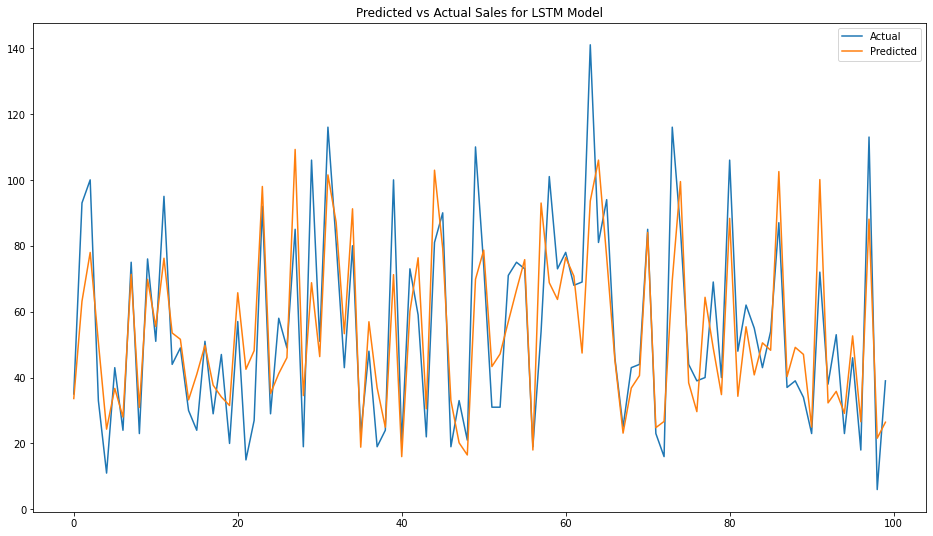

In [183]:
plot_pred_vs_act(Y_valid[:100],lstm_pred[:100],'LSTM')

<h1> XGBOOST </h1>

In [184]:
xgb_predictions = xboost(xgb_train_x, xgb_train_y, xgb_test_x, xgb_trained)


NameError: name 'xgb_train_x' is not defined